In [1]:

import numpy as np
import keras.applications
from keras.applications.resnet50 import preprocess_input as p_i, decode_predictions, ResNet50
from keras.preprocessing import image
import h5py
from keras.activations import softmax, relu, sigmoid
#from keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import preprocess_input
import h5py
from PIL import Image, ImageOps
import gdal
import keras.backend as K
from keras.layers import Dense, Input, Conv2D, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Add
from keras.layers.core import Dropout, Activation
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

Using TensorFlow backend.


In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [14]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [15]:
config = tf.ConfigProto(log_device_placement=True,
                                        allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

## Loading model

In [16]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name
def residual_conv_block(filters, stage, block, strides=(1, 1), attention=None, cut='pre'):
    def layer(input_tensor):

        # get params and names of layers
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
        else:
            raise ValueError('Cut type not in ["pre", "post"]')

        # continue with convolution layers
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = Activation('relu', name=relu_name + '2')(x)
        x = ZeroPadding2D(padding=(1, 1))(x)
        x = Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        # use attention block if defined
        if attention is not None:
            x = attention(x)

        # add residual connection
        x = Add()([x, shortcut])
        return x

    return layer


In [17]:
def build_resnet(
     repetitions=(2, 2, 2, 2),
     include_top=True,
     input_tensor=None,
     input_shape=None,
     classes=1000,
     block_type='conv',
     attention=None):
    
    """
    TODO
    """

    if input_tensor is None:
        img_input = Input(shape=input_shape, name='data')
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # choose residual block type
    if block_type == 'conv':
        residual_block = residual_conv_block
    elif block_type == 'bottleneck':
        residual_block = residual_bottleneck_block
    else:
        raise ValueError('Block type "{}" not in ["conv", "bottleneck"]'.format(block_type))

    attention_block = None

    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    # resnet bottom
    #x = BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    #x = Conv2D(3, (5,5), strides=(2, 2), name="myconv1", **conv_params)(x)
    #x = BatchNormalization(name='bn00', **bn_params)(x)
    #x = Conv2D(3, (5,5), strides=(2, 2), name="myconv2", **conv_params)(x)
    x = BatchNormalization(name='bn001', **bn_params)(img_input)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = BatchNormalization(name='bn0', **bn_params)(x)
    x = Activation('relu', name='relu0')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)
    
    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):
            
            filters = init_filters * (2**stage)
            
            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = residual_block(filters, stage, block, strides=(1, 1),
                                   cut='post', attention=attention_block)(x)
                
            elif block == 0:
                x = residual_block(filters, stage, block, strides=(2, 2),
                                   cut='post', attention=attention_block)(x)
                
            else:
                x = residual_block(filters, stage, block, strides=(1, 1),
                                   cut='pre', attention=attention_block)(x)
                
    x = BatchNormalization(name='bn1', **bn_params)(x)
    x = Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = Flatten(name='pool1')(x)
        x = Dense(classes, name='fc1')(x)
        x = Activation('softmax', name='softmax')(x)
    else:
        BottleneckLayer = {
            'flatten': Flatten(),
            'avg': GlobalAveragePooling2D(),
            'max': GlobalMaxPooling2D()
        }['flatten']
        x = BottleneckLayer(x)
        x = Dense(1, activation='linear')(x)
    # Ensure that the model takes into account any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x)

    return model

In [18]:

def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    default_bn_params = {
        'axis': 3,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params

In [19]:
model = build_resnet(input_shape=(224, 224, 3), include_top=False)
model.load_weights("checkpoint.hdf5")

In [46]:
X = np.load("perm_data/X_2731.npy")
y = np.load("perm_data/y_2731.npy")

In [470]:
imnum = 0
pred = model.predict(X[imnum:imnum + 1])[0][0]
pred

4.4490557

In [471]:
np.log(y[imnum])

3.9908341858524357

In [482]:
sq = np.full((5,5, 3), fill_value=0)

In [483]:
#temp[100:150,100:150] = sq
#plt.imshow(temp)

In [484]:
grid = []
for i in range(0, 224 - sq.shape[0], sq.shape[0]):
    row = []
    for j in range(0, 224 - sq.shape[1], sq.shape[1]):
        temp = X[imnum].copy()
        temp[i:i+sq.shape[0], j:j+sq.shape[1]] = sq
        row.append(model.predict(np.expand_dims(temp, axis=0)))
    grid.append(row)
        

In [485]:
grid = np.array(grid)
grid.shape

(44, 44, 1, 1)

In [486]:
grid2d = np.reshape(grid, grid.shape[:2])
grid2d.shape

(44, 44)

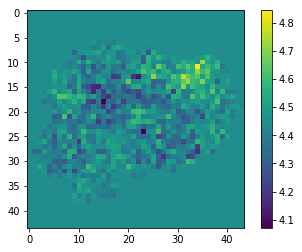

In [487]:
plt.imshow(grid2d)
plt.colorbar()

In [488]:
def resize(im, size=224):
    img = Image.fromarray(im)
    ratio = float(size/max(img.size))
    img = img.resize((int(ratio * img.size[0]), int(ratio * img.size[1])))
    return img


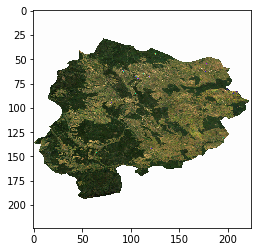

In [489]:
test = np.array(resize(grid2d))
test = pred - test
niceX = X[imnum].copy()
niceX[np.all(niceX == [0, 0, 0], axis=-1)] = 255
plt.imshow(niceX * 3)

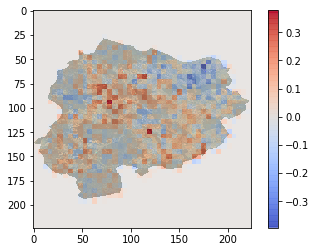

In [493]:
plt.figure()

plt.imshow(niceX * 3)
a = np.random.random((224, 224, 3))
plt.imshow(test, alpha=0.7, cmap='coolwarm')
plt.colorbar()
plt.show()

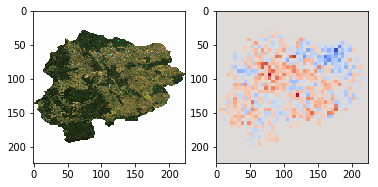

In [491]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(niceX * 3)
plt.subplot(1,2,2)
plt.imshow(test, cmap='coolwarm')
#plt.colorbar()
plt.show()

# Intermediate layer viz

In [497]:
classifier = build_resnet(input_shape=(224, 224, 3), include_top=False)
classifier.load_weights("checkpoint_datagen.hdf5")

RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

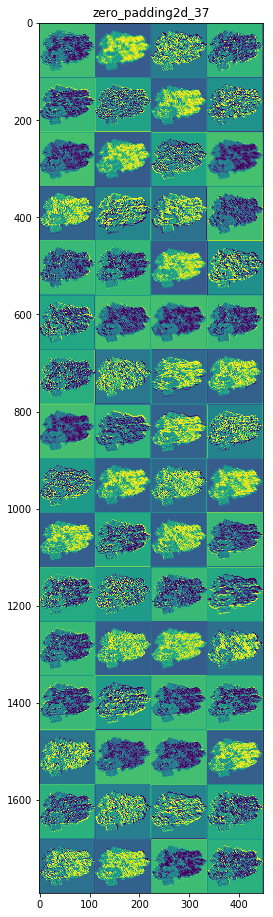

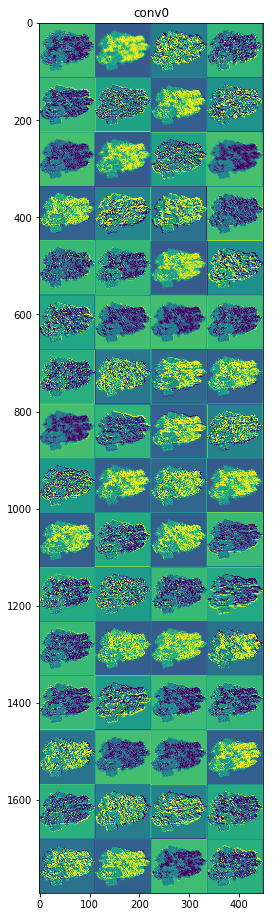

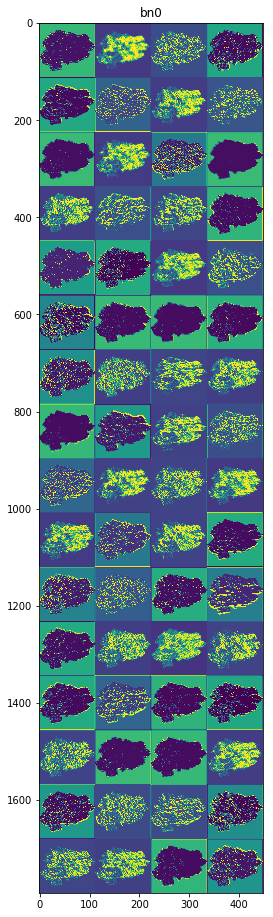

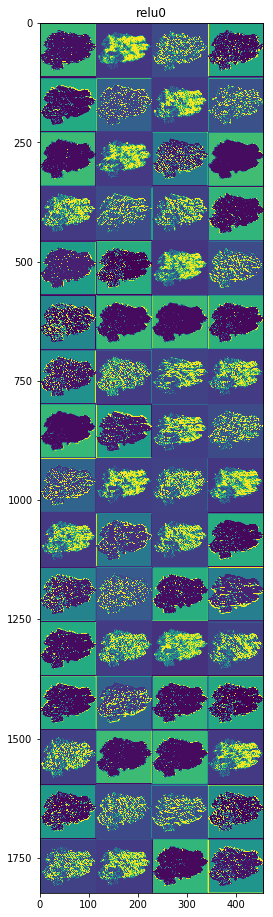

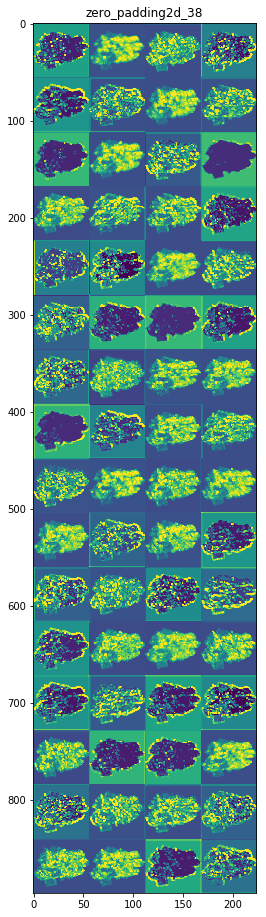

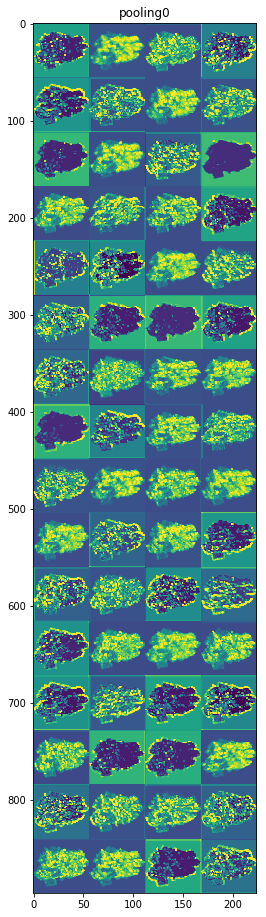

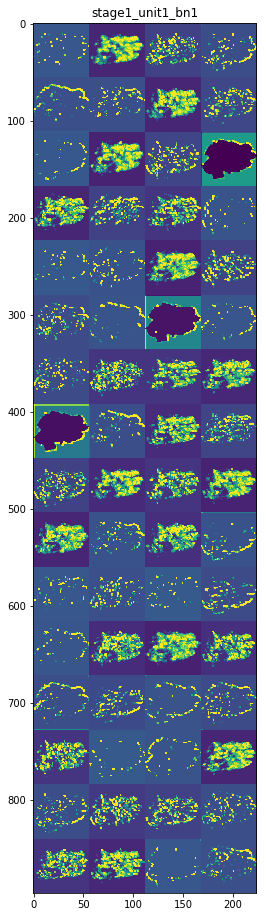

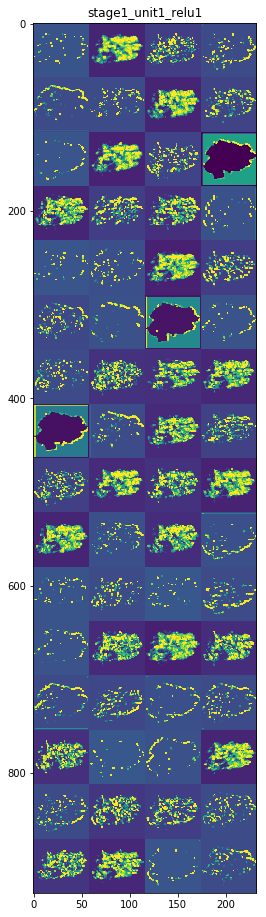

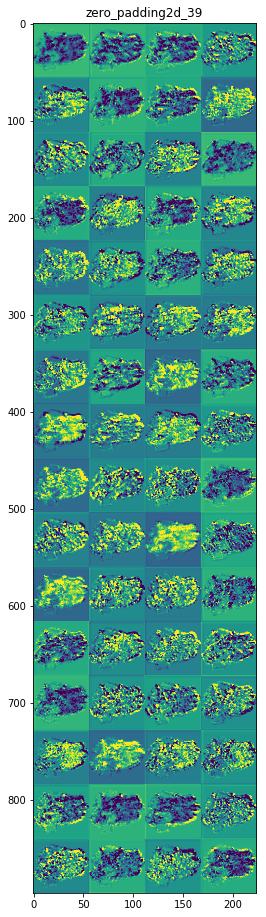

In [533]:
layer_outputs = [layer.output for layer in classifier.layers[:12]][1:]
activation_model = keras.models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X[:1]) 

layer_names = []
for layer in classifier.layers[:30]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [506]:
classifier2 = build_resnet(input_shape=(224, 224, 3), include_top=False)
classifier2.load_weights("checkpoint.hdf5")

RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 288x0 with 1 Axes>

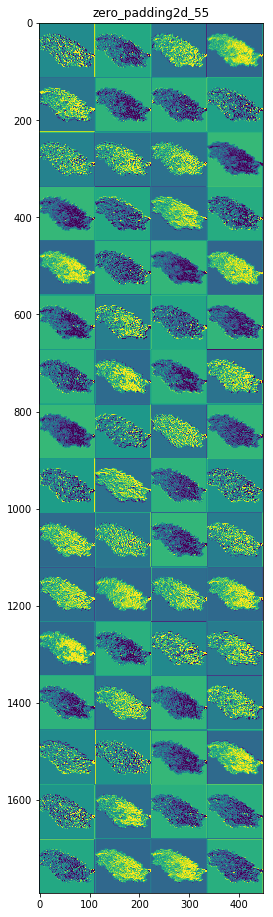

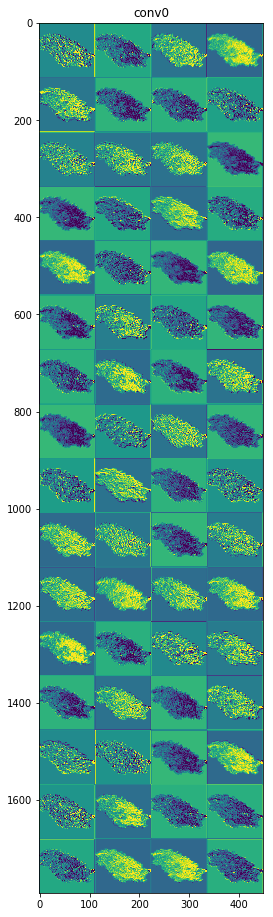

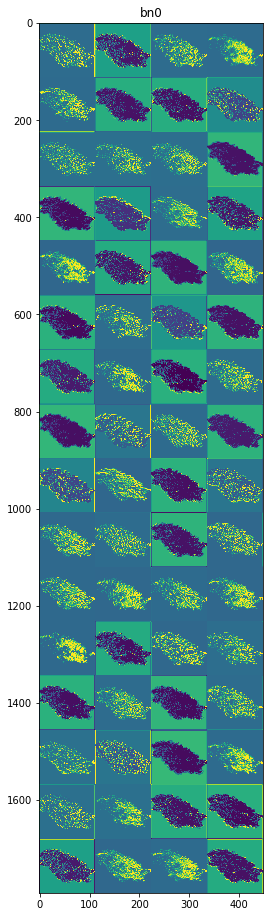

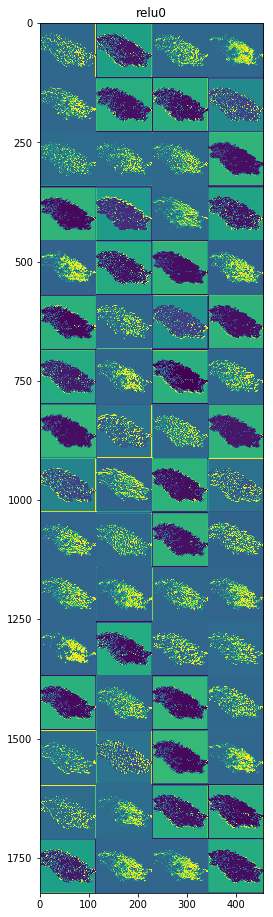

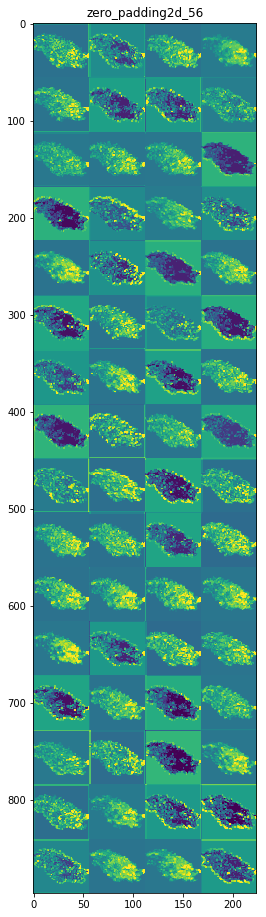

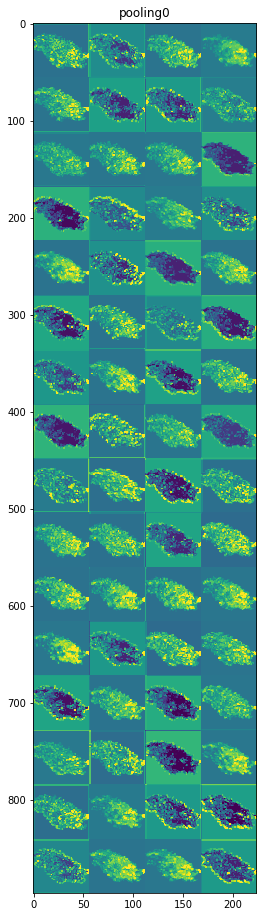

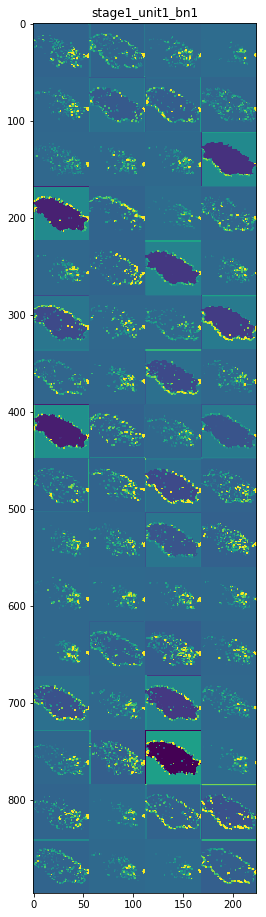

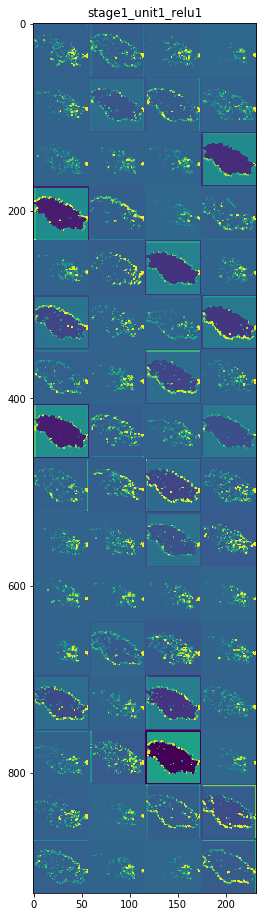

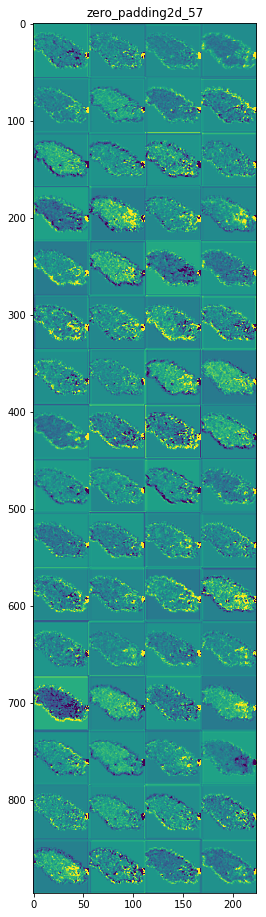

In [529]:
layer_outputs = [layer.output for layer in classifier2.layers[:12]][1:]
activation_model = keras.models.Model(inputs=classifier2.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(X[39:40]) 

layer_names = []
for layer in classifier2.layers[:30]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Find MSE

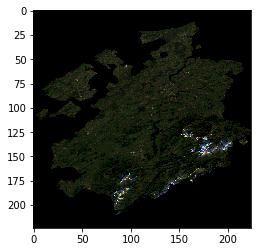

In [532]:
plt.imshow(X[50] * 3)